In [1]:
#export
import k1lib
from k1lib.cli import *
__all__ = ["trace"]

In [2]:
#export
traceIdxAuto = k1lib.AutoIncrement(prefix="TD_")
class TraceData:
    def __init__(self, _cli, inS, outS, name=None):
        """
:param inS: in and out strings to be displayed in the edges"""
        self.idx = traceIdxAuto()
        self.inS = inS; self.outS = outS; self.cli = _cli
        self.name = name or _cli.__class__.__name__
    def __str__(self):
        return f"<TraceData idx='{self.idx}' inS='{self.inS}' outS='{self.outS}' name='{self.name}' cli='{self.cli}'>"

In [3]:
#export
def isMTM(c):
    if not isinstance(c, BaseCli): return False
    if isinstance(c, (manyToMany, applyMp, applyTh)): return True
    if isinstance(c, apply) and isinstance(c.f, BaseCli) and c.column is None: return True
    return False

In [4]:
#export
class TraceException(Exception): pass
clusterAuto = k1lib.AutoIncrement()
emptyInputSentinel = object()
class _trace(BaseCli):
    def __init__(self, inp, f, g=None, depth=None):
        """
Some notes. startTd will always tries to grab the first thing, lastTd will only
grab the last thing at the end of __ror__, hence "last" and not "end".

:param inp: initial input to pipe into other cli tools
:param f: function to display result of cli tools, default just shows the shape of the stream
:param env: :class:`graphviz.dot.Digraph` to use (hence subgraph, hence no "start" and "end")"""
        if depth is None: depth = k1lib.MaxDepth(float("inf"), 0)
        self.inp = inp # will change constantly as new clis are being piped into by trace
        self.f = f; self.depth = depth; self._reprRO = k1lib.RunOnce()
        if g is None:
            self.lastTd = TraceData(None, None, None, "\\<start\\>")
            self.g = k1lib.digraph(); self._formNode(self.lastTd)
        else: self.g = g; self.lastTd = None
        self.firstTime = True # every other time other than the first should not record any data. It should just pass data through
    def _formNode(self, td:TraceData, g=None): (g or self.g).node(td.idx, td.name)
    def _formEdge(self, td1:TraceData, td2:TraceData, g=None, label:str=None):
        if td1 is None or td2 is None: return
        (g or self.g).edge(td1.idx, td2.idx, label=f" {label or td2.inS or td1.outS}")
    def _run(self, c, inp, cliName=None):
        """Takes in cli tool and input, runs it, and get trace data and output"""
        if isinstance(c, op): c.op_solidify()
        out = c(inp) | deref() # why not "inp | c"? Cause we want to serve plain old functions inside apply too
        return TraceData(c, f"{self.f(inp)}", f"{self.f(out)}", cliName), out
    def __repr__(self):
        try: from IPython.core import display as dis
        except: raise RuntimeError("You have to install IPython/execute in a notebook first!")
        if not self._reprRO():
            td = TraceData(None, self.lastTd.outS, None, "\\<end\\>")
            self._formNode(td); self._formEdge(self.lastTd, td)
        dis.display(dis.SVG(k1lib.scaleSvg(self.g._repr_svg_()))); return "<trace object>"
    def __ror__(self, it):
        """Alternative way to specify input."""
        #if self.inp != emptyInputSentinel: raise TraceException("Input to trace has already been set, but it's being set again (possibly due to `.all()`). Check last trace using ``trace.last``")
        if self.inp != emptyInputSentinel: self.firstTime = False
        self.inp = it | deref(); return self
    def __iter__(self): return self.inp

In [5]:
#export
@k1lib.patch(_trace)
def __or__(self, c):
    if self.inp is emptyInputSentinel:
        # do this to separate out potentially a serial right after this, so that trace() is actually in control, and not merge with the outside serial
        if isinstance(c, serial): return serial(self, c)
        return super(_trace, self).__or__(c)
    if not isinstance(c, BaseCli): return NotImplemented
    if self._reprRO.value: raise RuntimeError("Can't pipe this trace() into another cli tool, as it is used! Make a new trace instead.")
    td, out = self._run(c, self.inp) # runs through the entire thing, then decides whether to go into the details or not
    if not self.firstTime: return out
    if not hasattr(self, "startTd"): self.startTd = td; startTdSet = True
    else: startTdSet = False # whether startTd is set lately
    def bypass(): # default connection case, don't go into clis and explore
        self._formNode(td); self._formEdge(self.lastTd, td); self.lastTd = td
    if self.depth and isinstance(c, serial):
        with self.g.subgraph(name=f"cluster_{clusterAuto()}") as subG:
            subG.attr(label="|, serial")
            t = _trace(self.inp, self.f, subG, self.depth.enter())
            for _c in c.clis: t = t | _c
        self._formEdge(self.lastTd, t.startTd); self.lastTd = t.lastTd
        if startTdSet: self.startTd = t.startTd
    elif self.depth and isMTM(c):
        if isinstance(c, (apply, applyMp)): _c = c.f
        elif isinstance(c, manyToMany): _c = c.cli
        try: singleInp = self.inp | item()
        except StopIteration: bypass() # no items at all, can't trace!
        else:
            with self.g.subgraph(name=f"cluster_{clusterAuto()}") as subG:
                subG.attr(label=".all(), manyToMany, apply")
                t = _trace(self.inp | item(), self.f, subG, self.depth.enter())
                o1Td = TraceData(None, self.f(self.inp), None, "*"); self._formNode(o1Td, g=subG); t = t | _c
                o2Td = TraceData(None, self.f(t.inp),    None, "*"); self._formNode(o2Td, g=subG)
                t._formEdge(o1Td, t.startTd); t._formEdge(t.lastTd, o2Td); o2Td.outS = self.f(out)
            self._formEdge(self.lastTd, o1Td); self.lastTd = o2Td
            if startTdSet: self.startTd = o1Td
    elif self.depth and isinstance(c, oneToMany):
        with self.g.subgraph(name=f"cluster_{clusterAuto()}") as subG:
            subG.attr(label="&, oneToMany")
            o1Td = TraceData(None, self.f(self.inp), None, "*"); self._formNode(o1Td, g=subG)
            o2Td = TraceData(None, None,             None, "*"); self._formNode(o2Td, g=subG)
            for _c in c.clis:
                t = _trace(self.inp, self.f, subG, self.depth.enter()) | _c
                self._formEdge(o1Td, t.startTd); self._formEdge(t.lastTd, o2Td)
        self._formEdge(self.lastTd, o1Td); self.lastTd = o2Td; o2Td.outS = self.f(out)
        if startTdSet: self.startTd = o1Td
    elif self.depth and isinstance(c, manyToManySpecific):
        with self.g.subgraph(name=f"cluster_{clusterAuto()}") as subG:
            subG.attr(label="+, manyToManySpecific")
            o1Td = TraceData(None, self.f(self.inp), None, "*"); self._formNode(o1Td, g=subG)
            o2Td = TraceData(None, None, self.f(out),      "*"); self._formNode(o2Td, g=subG)
            for _c, _it in zip(c.clis, self.inp):
                t = _trace(_it, self.f, subG, self.depth.enter()) | _c
                self._formEdge(o1Td, t.startTd); self._formEdge(t.lastTd, o2Td)
        self._formEdge(self.lastTd, o1Td); self.lastTd = o2Td; o2Td.outS = self.f(out)
        if startTdSet: self.startTd = o1Td
    elif self.depth and isinstance(c, apply) and isinstance(c.f, BaseCli) and c.column is not None:
        try: singleInp = self.inp | item()
        except StopIteration: bypass()
        else:
            with self.g.subgraph(name=f"cluster_{clusterAuto()}") as subG:
                subG.attr(label=f"apply (column: {c.column})")
                singleInp = singleInp[c.column]
                t = _trace(singleInp, self.f, subG, self.depth.enter()) | c.f
                o1Td = TraceData(None, self.f(self.inp), None, "*"); self._formNode(o1Td, g=subG)
                o2Td = TraceData(None, self.f(t.inp),    None, "*"); self._formNode(o2Td, g=subG)
                t._formEdge(o1Td, t.startTd); t._formEdge(t.lastTd, o2Td); o2Td.outS = self.f(out)
            self._formEdge(self.lastTd, o1Td); self.lastTd = o2Td
            if startTdSet: self.startTd = o1Td
    elif self.depth and isinstance(c, filt) and isinstance(c.predicate, BaseCli):
        try: singleInp = self.inp | item()
        except StopIteration: bypass()
        else:
            with self.g.subgraph(name=f"cluster_{clusterAuto()}") as subG:
                subG.attr(label=f"filt (column: {c.column})")
                self._formNode(td, g=subG); self._formEdge(self.lastTd, td) # main filt node
                if c.column is not None: singleInp = singleInp[c.column]
                t = _trace(singleInp, self.f, subG, self.depth.enter()) | c.predicate
                tdEndFilt = td; #tdEndFilt = TraceData(None, None, None, "*"); self._formNode(tdEndFilt, g=subG) # can switch between styles
                self._formEdge(td, t.startTd); self._formEdge(t.lastTd, tdEndFilt, label=f"{t.lastTd.outS}")
                self.lastTd = td
            if startTdSet: self.startTd = td
    else: bypass()
    self.inp = out; return self

In [6]:
#export
class trace(_trace):
    last = None
    """Last instantiated trace object. Access this to view the previous (possibly nested) trace."""
    def __init__(self, f=shape(), maxDepth=float("inf")):
        """Traces out how the data stream is transformed through complex cli tools.
Example::

    # returns [1, 4, 9, 16], normal command
    range(1, 5) | apply(lambda x: x**2) | deref()
    # traced command, will display how the shapes evolve through cli tools
    range(1, 5) | trace() | apply(lambda x: x**2) | deref()

There're a lot more instructions and code examples over the tutorial section. Go check it out!

:param f: function to display the data stream. Defaulted to :class:`~k1lib.cli.utils.shape`,
    and to :class:`~k1lib.cli.utils.iden` if is None."""
        f = f or iden()
        g = lambda x: f"{f(x)}".split("\n")[:2] | apply(lambda s: f"{s[:50]}..." if len(s) > 50 else s) | join("\n")
        super().__init__(emptyInputSentinel, g, depth=k1lib.MaxDepth(maxDepth))
        trace.last = self

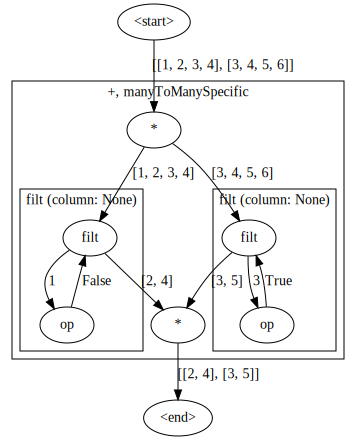

<trace object>

In [7]:
[range(1, 5), range(3, 7)] | trace(iden()) | (filt(op() % 2 == 0) + filt(op() % 2 == 1))

In [8]:
!../../export.py cli/trace

Current dir: /home/kelvin/repos/labs/k1lib, ../../export.py
rm: cannot remove '__pycache__': No such file or directory
Found existing installation: k1lib 0.11
Uninstalling k1lib-0.11:
  Successfully uninstalled k1lib-0.11
running install
running bdist_egg
running egg_info
creating k1lib.egg-info
writing k1lib.egg-info/PKG-INFO
writing dependency_links to k1lib.egg-info/dependency_links.txt
writing requirements to k1lib.egg-info/requires.txt
writing top-level names to k1lib.egg-info/top_level.txt
writing manifest file 'k1lib.egg-info/SOURCES.txt'
reading manifest file 'k1lib.egg-info/SOURCES.txt'
adding license file 'LICENSE'
writing manifest file 'k1lib.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/k1lib
copying k1lib/_learner.py -> build/lib/k1lib
copying k1lib/fmt.py -> build/lib/k1lib
copying k1lib/_context.py -> build/lib/k1lib
copying k1lib/selector.py -> build